## Parameter management


### Some prerequisites & basic definitions

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
pd.set_option("mode.chained_assignment", None) 
import eaopack as eao
import matplotlib.pyplot as plt

### Load sample portfolio (and the timegrid)
The portfolio comes prefefined in a JSON. Let us have a look. 

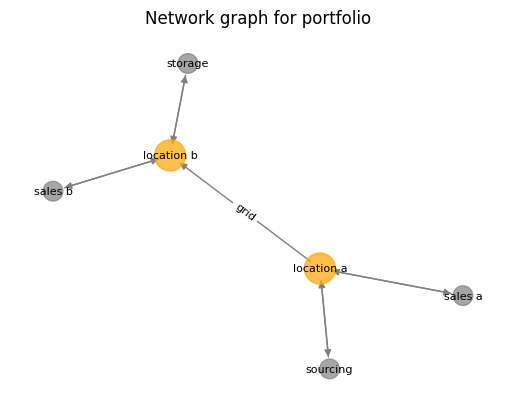

In [2]:
timegrid = eao.serialization.load_from_json(file_name='timegrid.json')
portf    = eao.serialization.load_from_json(file_name='portfolio_simple_start.json')
eao.network_graphs.create_graph(portf)

As we can see. the portfolio is a simple setup with a sourcing possibility and two sales contracts at two locations. For flexibility there is a storage (which we will manipulate in the following).

## Looking at parameters and setting them to new values
As the next step we look at the parameters that define the portfolio. To this end, EAO provides three routines:
* eao.io.get_params_tree   - to retrieve parameters as a dict and the paths to the parameters. To be used mainly with assets & portfolios
* get_param                - to get parameter values using the path
* set_param                - to change the parameters

In [3]:
[params, param_dict] = eao.io.get_params_tree(portf)
for p in params:
    print(p)

__class__
['assets', 0, '__class__']
['assets', 0, 'asset_type']
['assets', 0, 'end']
['assets', 0, 'extra_costs']
['assets', 0, 'freq']
['assets', 0, 'max_cap']
['assets', 0, 'min_cap']
['assets', 0, 'name']
['assets', 0, 'nodes', 0, '__class__']
['assets', 0, 'nodes', 0, 'commodity']
['assets', 0, 'nodes', 0, 'name']
['assets', 0, 'nodes', 0, 'unit', '__class__']
['assets', 0, 'nodes', 0, 'unit', 'factor']
['assets', 0, 'nodes', 0, 'unit', 'flow']
['assets', 0, 'nodes', 0, 'unit', 'volume']
['assets', 0, 'periodicity']
['assets', 0, 'periodicity_duration']
['assets', 0, 'price']
['assets', 0, 'profile']
['assets', 0, 'start']
['assets', 0, 'wacc']
['assets', 1, '__class__']
['assets', 1, 'asset_type']
['assets', 1, 'end']
['assets', 1, 'extra_costs']
['assets', 1, 'freq']
['assets', 1, 'max_cap']
['assets', 1, 'min_cap']
['assets', 1, 'name']
['assets', 1, 'nodes', 0, '__class__']
['assets', 1, 'nodes', 0, 'commodity']
['assets', 1, 'nodes', 0, 'name']
['assets', 1, 'nodes', 0, 'unit

Looking at the parameter tree, note that we extracted the whole tree of parameters in the portfolio. Each entry is a list, that points downwards into the nested object (portfolio --> asset, --> ...).

To access the parameter, we can use any of those entries. Let us concentrate on the storage (asset no. 4):

In [4]:
param_dict['assets'][4]


{'__class__': 'Asset',
 'asset_type': 'Storage',
 'block_size': None,
 'cap_in': 30,
 'cap_out': 30,
 'cost_in': 0.2,
 'cost_out': 0.2,
 'cost_store': 0.0,
 'eff_in': 1.0,
 'eff_out': 1.0,
 'end': None,
 'end_level': 5,
 'freq': None,
 'inflow': 0.0,
 'max_cycles_freq': 'd',
 'max_cycles_no': None,
 'max_store_duration': None,
 'name': 'storage',
 'no_simult_in_out': False,
 'nodes': [{'__class__': 'Node',
   'commodity': None,
   'name': 'location b',
   'unit': {'__class__': 'Unit',
    'factor': 1.0,
    'flow': 'MW',
    'volume': 'MWh'}}],
 'periodicity': None,
 'periodicity_duration': None,
 'price': None,
 'profile': None,
 'size': 48,
 'start': None,
 'start_level': 5,
 'wacc': 0.0}

Now, get direct access via tree entries, e.g. the fill level on start up

In [5]:
print(eao.io.get_param(portf, ['assets', 4, 'start_level']))

5


Going via the complete portfolio is one way. However, it is also possible to directly go via specific assets:

In [6]:
print(eao.io.get_param(portf.get_asset('sales b'), ['price']))

price sales b


Let us manipulate the fill level. Note that this could also be done by diving directly into the object ...

In [7]:
portf.get_asset('storage').start_level = 4
print(portf.get_asset('storage').start_level)

4


... but setting parameters this way is actually relatively insecure, since this circumvents proper initialization. Therefore, it is better to use the set_param routine:

In [8]:
portf = eao.io.set_param(portf,['assets', 4, 'start_level'], 6 )
print(portf.get_asset('storage').start_level)

6


This routine properly extracts parameters using the serialization machinery and re-initiates the objects. Therefore, all tests are called.

Let us take a look by setting an invalid parameter. In this case we set the storage size to a value which is smaller than the initial fill level:

In [9]:
try:
    portf = eao.io.set_param(portf, ['assets', 4, 'size'], 1.)
except Exception as error:
    print('Not possible')
    pass


Not possible


### Sample: Looping different parameters

Here we do a simple loop on the storage size to demonstrate how to manipulate parameters for parameter studies or how to react to live data

In [10]:
# sample prices
prices = {'price sourcing': 5.*np.sin(np.linspace(0.,6., timegrid.T)),
         'price sales a' : np.ones(timegrid.T)*2.,
         'price sales b' : 5.+5.*np.sin(np.linspace(0.,6., timegrid.T))  }

Current storage size

In [11]:
print(eao.io.get_param(portf, ['assets', 4, 'size']))
print(eao.io.get_param(portf, ['assets', 4, 'nodes', 0,'unit','volume']))

48
MWh


In [12]:
storage_sizes = range(10, 150, 5)
values = [] # collect results

for my_size in storage_sizes:
    portf = eao.io.set_param(portf, ['assets', 4, 'size'], my_size )
    optim_problem  = portf.setup_optim_problem(timegrid = timegrid, prices=prices)
    result         = optim_problem.optimize()
    values.append(result.value)
# output = eao.io.extract_output(portf, optim_problem, result)

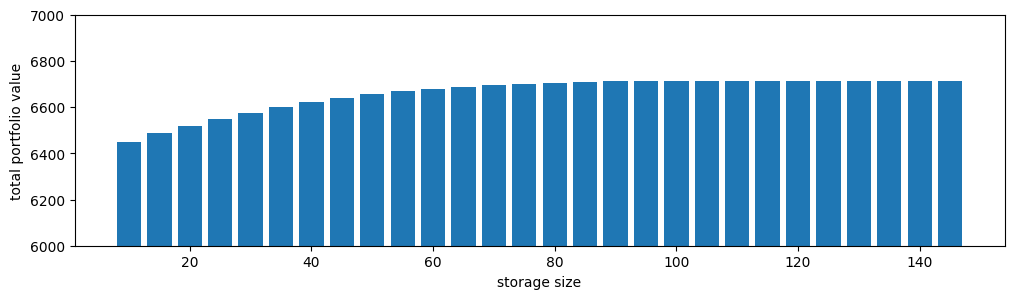

In [13]:
fig = plt.figure(figsize = (12,3))
plt.bar(storage_sizes, values, width = 4)
plt.ylim((6000, 7000))
plt.xlabel('storage size')
plt.ylabel('total portfolio value')
plt.show()

This is just for demonstration purpose. However - neat to see how the value add of extra storage size decreases.